In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [90]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower()


In [91]:
# trades timestamp (milliseconds → datetime)
trades["timestamp"] = pd.to_datetime(
    trades["timestamp"],
    unit="ms",
    errors="coerce"
)

# normalize to midnight (keeps dtype consistent)
trades["trade_date"] = trades["timestamp"].dt.normalize()

# sentiment date (already provided — DO NOT recompute)
sentiment["date"] = pd.to_datetime(
    sentiment["date"],
    errors="coerce"
).dt.normalize()


In [92]:
print("Trade date range:")
print(trades["trade_date"].min(), "→", trades["trade_date"].max())

print("\nSentiment date range:")
print(sentiment["date"].min(), "→", sentiment["date"].max())

print("\nOverlapping dates:",
      len(set(trades["trade_date"]).intersection(set(sentiment["date"]))))


Trade date range:
2023-03-28 00:00:00 → 2025-06-15 00:00:00

Sentiment date range:
2018-02-01 00:00:00 → 2025-05-02 00:00:00

Overlapping dates: 6


In [93]:
df = trades.merge(
    sentiment[["date", "classification"]],
    left_on="trade_date",
    right_on="date",
    how="inner"
)

print("Rows after merge:", len(df))
df.head()


Rows after merge: 184263


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,trade_date,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-10-27 03:33:20,2024-10-27,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-10-27 03:33:20,2024-10-27,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-10-27 03:33:20,2024-10-27,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-10-27 03:33:20,2024-10-27,2024-10-27,Greed


In [94]:
df["closed_pnl"] = pd.to_numeric(df["closed_pnl"], errors="coerce")
df["size_usd"] = pd.to_numeric(df["size_usd"], errors="coerce")

df = df.dropna(subset=["closed_pnl"])
df = df[df["size_usd"] != 0]

print("Usable trades:", len(df))


Usable trades: 184220


In [95]:
sentiment_perf = (
    df.groupby("classification")
      .agg(
          avg_pnl=("closed_pnl", "mean"),
          median_pnl=("closed_pnl", "median"),
          total_pnl=("closed_pnl", "sum"),
          trade_count=("closed_pnl", "count"),
          win_rate=("closed_pnl", lambda x: (x > 0).mean())
      )
      .reset_index()
      .sort_values("avg_pnl", ascending=False)
)

sentiment_perf


,classification,avg_pnl,median_pnl,total_pnl,trade_count,win_rate
2,Greed,87.923933,0.0,3.189617e+06,36277,0.446619
1,Fear,50.052108,0.0,6.699925e+06,133859,0.415183
0,Extreme Greed,25.418772,0.0,1.769655e+05,6962,0.490089
3,Neutral,22.289017,0.0,1.587424e+05,7122,0.318029


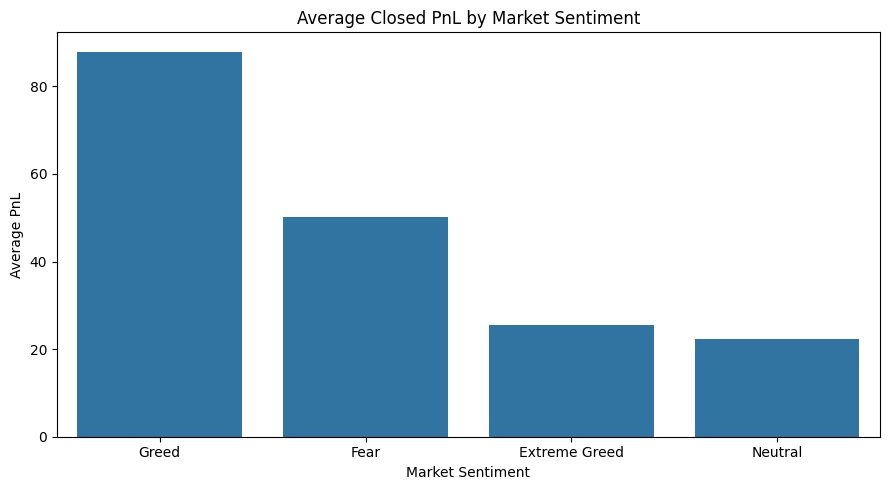

In [96]:
plt.figure(figsize=(9,5))
sns.barplot(
    data=sentiment_perf,
    x="classification",
    y="avg_pnl"
)
plt.title("Average Closed PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.show()


In [97]:
trader_perf = (
    df.groupby("account")
      .agg(
          total_pnl=("closed_pnl", "sum"),
          trades=("closed_pnl", "count")
      )
      .reset_index()
)

trader_perf.describe()


,total_pnl,trades
count,3.200000e+01,32.00000
mean,3.195390e+05,5756.87500
std,4.632773e+05,7588.43215
min,-2.770457e+04,332.00000
25%,4.954873e+04,1113.25000
50%,1.207566e+05,3152.50000
75%,3.961377e+05,7689.00000
max,2.040922e+06,36524.00000


In [98]:
top_traders = trader_perf.nlargest(20, "total_pnl")["account"]
bottom_traders = trader_perf.nsmallest(20, "total_pnl")["account"]

df["trader_group"] = np.where(
    df["account"].isin(top_traders), "Top",
    np.where(df["account"].isin(bottom_traders), "Bottom", "Middle")
)


In [99]:
group_perf = (
    df.groupby(["trader_group", "classification"])
      .agg(avg_pnl=("closed_pnl", "mean"))
      .reset_index()
)

group_perf


,trader_group,classification,avg_pnl
0,Bottom,Extreme Greed,-206.074672
1,Bottom,Fear,9.095773
2,Bottom,Greed,73.265899
3,Bottom,Neutral,-5.968878
4,Top,Extreme Greed,26.320044
5,Top,Fear,58.638730
6,Top,Greed,89.318230
7,Top,Neutral,56.942259


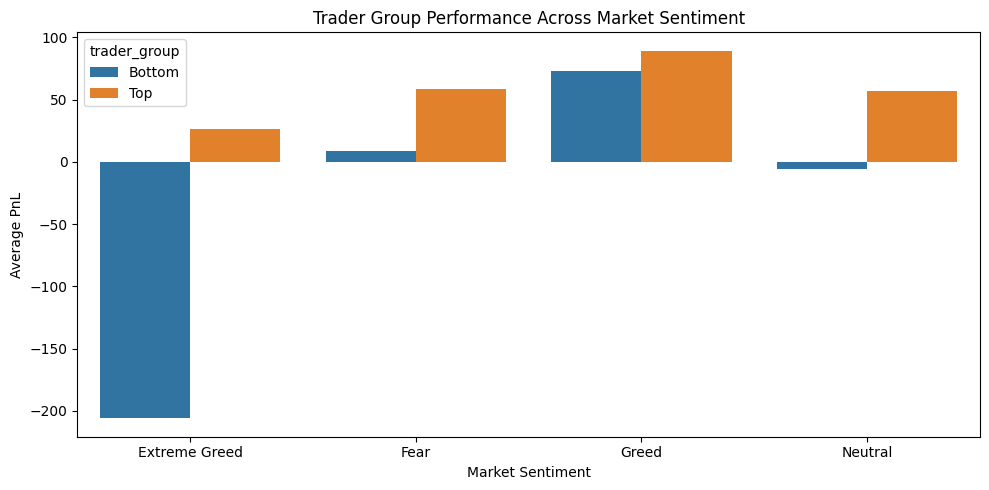

In [100]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=group_perf,
    x="classification",
    y="avg_pnl",
    hue="trader_group"
)
plt.title("Trader Group Performance Across Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.show()


In [101]:
trade_freq = (
    df.groupby("account")
      .size()
      .reset_index(name="trade_count")
)

freq_perf = trade_freq.merge(
    trader_perf[["account", "total_pnl"]],
    on="account"
)

freq_perf["trade_count"].corr(freq_perf["total_pnl"])


np.float64(0.42230923840479295)